In [52]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from sklearn.feature_extraction.text import TfidfTransformer
import datetime
import numpy as np
import networkx as nx
import pickle

In [2]:
with open("./preprocessed_bitcoin.pkl", 'rb') as f:
    data = pickle.load(f)

voca2idx = {w: i for i, w in enumerate(data['voca'])}
voca = data['voca']

In [3]:
prices_list = []
# format
# Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
with open("data/BTC/bitcoin_price.csv") as f:
    next(f)
    for i, line in enumerate(f):
        price = {}
        line = line[:-1]
        timestamp, open_, high, low, close, volume, market_cap, weighted_price = line.split(',')
        price['date'] = datetime.date.fromtimestamp(int(timestamp))
        price['open'] = float(open_.replace(',', ''))
        price['high'] =  float(high.replace(',', ''))
        price['low'] =  float(low.replace(',', ''))
        price['close'] =  float(close.replace(',', ''))
        try:
            price['volume'] =  float(volume.replace(',', ''))
        except:
            break
        price['market_cap'] =  float(market_cap.replace(',', ''))
        prices_list.append(price)
        
prices_list.reverse()
# prices_list = prices_list[521:-27] # Feb 02, 2018까지
# print(len(prices_list))

4857377


In [4]:
# 전체 토픽 분석!

In [5]:
time_list = sorted(list(data['time_posts'].keys()))
time_list = [t for t in time_list if t>= datetime.datetime(2015, 6, 1).date()]

tdm = np.zeros((len(time_list), len(voca)), dtype=np.float32)
for i, time in enumerate(time_list):
    for post in data['time_posts'][time]:
        for word in post:
            tdm[i, voca2idx[word]] += 1
            
tdm = normalize(tdm)

In [6]:
# print(data['time_posts'].keys())
# fix the length of the prices_list so that it matches the number of documents or posts

price_dict = {}
# price_dict


for dict in prices_list:
    if dict['date'] in time_list and not(np.isnan(dict['high'])):
        price_dict[dict['date']] = dict['high']


In [7]:
K = 10
nmf = NMF(n_components=K, alpha=0.1, max_iter=500)
W = nmf.fit_transform(tdm).T
H = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [65]:
from scipy.stats import pearsonr
prices = np.array(list(price_dict.values()), dtype=np.float32)

topic_time_correlation = []
for k in range(K):
    topic_time_correlation.append(pearsonr(prices, W[k, :]))
    
topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

for k in top_topic:
    print(f"{k+1}th topic, correlation: %f, p-value: %.2e" % (topic_time_correlation[k,0], topic_time_correlation[k,1]))
    for i in H[k, :].argsort()[::-1][:30]:
        print(voca[i], end=' ')
    print()

9th topic, correlation: -0.111314, p-value: 4.17e-02
airdrop get free token join bounty user verified top last chance kyc xrp gaming bonus earn app freecoins hurry freetokens link cryptocurrencies total btc member tradingbot ripple store catch listing 
6th topic, correlation: -0.086819, p-value: 1.13e-01
buy now price sell coin usd volume daily type exchange bitcoin network market decentralized energy gold address cool crowdsale freetoken central poa african available xrp bank seriously erc freelance dash 
1th topic, correlation: 0.084717, p-value: 1.22e-01
bitcoin money price mining new year value first miner market currency wallet back time world get via altcoins since real make lightning know gold moon give satoshi hardware investment trump 
2th topic, correlation: -0.084072, p-value: 1.25e-01
btc eth altcoin last ltc coin smart market blockchain wallet money new best binance time good doge typical eur secure order win trader hardware network app news update check usd 
5th topic, co

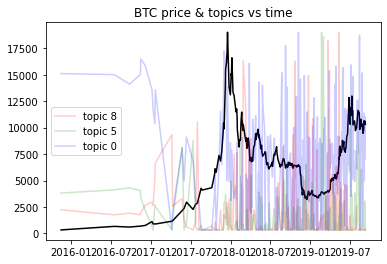

In [64]:
# from pyecharts.charts import Line
# from bokeh.palettes import Set1

# line = Line()
# for k in  top_topic[:3]:
#     line.add(f"topic {k+1}",
#              time_list, W[k], is_fill=True, is_stack=True, is_symbol_show=False,
#              line_width=0.2, area_opacity=0.4,
#              label_color=Set1[7], is_smooth=True, x_axis_type='time')

# line.height = 500
# line.width = 800
# line
# Couldn't get the original plotting software to work, going to try it with matplotlib instead

import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'magenta', 'violet', 'pink', 'cyan']

W_scaled = W.copy()

for i, row in enumerate(W):
    W_scaled[i] = minmax_scale(row, (min(price_dict.values()), max(price_dict.values())), copy=True)


plt.plot(price_dict.keys(), price_dict.values(), color='black')
for i, k in enumerate(top_topic[:3]):
    plt.plot(price_dict.keys(), W_scaled[k, :], color=colors[i], alpha=0.2, label=f"topic {k}")

plt.title("BTC price & topics vs time")
plt.legend(loc='best')
plt.show()


335

In [ ]:
# network analysis
# user_score = nx.pagerank(data['user_network'], tol=1e-8, max_iter=200)
_, user_score = nx.hits(data['user_network'], max_iter=500) # output: hubs, authority
total_user_num = len(data['user_network'].nodes())

In [ ]:
# 상위 유저 분석!
top_users = sorted(user_score, key=user_score.get, reverse=True)

acc_sum = 0
top_index = 0
score_sum = sum(user_score.values())
for i, top_user in enumerate(top_users):
    acc_sum += user_score[top_user]/score_sum
    if acc_sum > 0.8:
        top_index = i
        break

top_users = top_users[:top_index]

In [ ]:
time_list = set()
for top_user in top_users:
    time_list.update(data['user_time_posts'][top_user].keys())

time_list = sorted(time_list)
time_list = [t for t in time_list if t>= datetime(2015, 6, 1).date()]
time_list_dict = {t: i for i, t in enumerate(time_list)}
print(len(time_list))
print(time_list[0], time_list[-1])

977
2015-06-01 2018-02-01


In [ ]:
tdm = np.zeros((len(time_list), len(voca)), dtype=np.float32)
for top_user in top_users:
    for time, posts in data['user_time_posts'][top_user].items():
        if time in time_list_dict:
            for post in posts:
                for word in post:
                    tdm[time_list_dict[time], voca2idx[word]] += 1
                    
tdm = normalize(tdm)

In [ ]:
nmf = NMF(n_components=K, alpha=0.1, max_iter=500)
W = nmf.fit_transform(tdm).T
H = nmf.components_

In [ ]:
from scipy.stats import pearsonr
prices = np.array([p['high'] for p in prices_list if p['date'] in time_list_dict])
topic_time_correlation = []
for k in range(K):
    topic_time_correlation.append(pearsonr(prices, W[k, :]))
    
topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

for k in top_topic[:5]:
    print(f"{k+1}th topic, correlation: %f, p-value: %.2e" % (topic_time_correlation[k,0], topic_time_correlation[k,1]))
    for i in H[k, :].argsort()[::-1][:30]:
        print(voca[i], end=' ')
    print()

2th topic, correlation: 0.584437, p-value: 1.46e-90
bitcoin price currency exchange now market value time year cryptocurrency crypto day gold buy government china money world trading mining new investment investor digital big high future country news make 
9th topic, correlation: 0.191275, p-value: 1.67e-09
coin bitcoin money get know now exchange make good time take crypto world back keep sell need buy alt give mean everyone never new lose right since first fiat start 
1th topic, correlation: -0.162797, p-value: 3.12e-07
block size transaction node bitcoin miner network time limit mining new increase chain change number minute full version add bip every consensus first reward system code fix mined need total 
7th topic, correlation: -0.119300, p-value: 1.86e-04
satoshi know nakamoto wright time blockchain craig bitcoin claim technology now key work group year world munity get project address make first forum trying node back gavin give might news 
6th topic, correlation: 0.114232, p-v

In [ ]:
from pyecharts import Line
from bokeh.palettes import Set1

line = Line()
for k in  top_topic[:3]:
    line.add(f"topic {k+1}",
             time_list, W[k], is_fill=True, is_stack=True, is_symbol_show=False,
             line_width=0.2, area_opacity=0.4,
             label_color=Set1[7], is_smooth=True, x_axis_type='time')

line.height = 500
line.width = 800
line

In [ ]:
# 하위 유저 분석!
#low_users = sorted(user_score, key=user_score.get, reverse=False)[:int(total_user_num*0.8)]
low_users = sorted(user_score, key=user_score.get, reverse=False)[:-top_index]

In [ ]:
time_list = set()
for low_user in low_users:
    time_list.update(data['user_time_posts'][low_user].keys())

time_list = sorted(time_list)
time_list = [t for t in time_list if t>= datetime(2015, 6, 1).date()]
time_list_dict = {t: i for i, t in enumerate(time_list)}
print(len(time_list))
print(time_list[0], time_list[-1])

735
2015-06-01 2018-02-01


In [ ]:
tdm = np.zeros((len(time_list), len(voca)), dtype=np.float32)
for low_user in low_users:
    for time, posts in data['user_time_posts'][low_user].items():
        if time in time_list_dict:
            for post in posts:
                for word in post:
                    tdm[time_list_dict[time], voca2idx[word]] += 1
                    
tdm = normalize(tdm)

In [ ]:
nmf = NMF(n_components=K, alpha=0.1, max_iter=500)
W = nmf.fit_transform(tdm).T
H = nmf.components_

In [ ]:
from scipy.stats import pearsonr
prices = np.array([p['high'] for p in prices_list if p['date'] in time_list_dict])
topic_time_correlation = []
for k in range(K):
    topic_time_correlation.append(pearsonr(prices, W[k, :]))
    
topic_time_correlation = np.array(topic_time_correlation) # pearson correlation and p-value
top_topic = np.argsort(np.abs(topic_time_correlation[:,0]))[::-1]

for k in top_topic[:5]:
    print(f"{k+1}th topic, correlation: %f, p-value: %.2e" % (topic_time_correlation[k,0], topic_time_correlation[k,1]))
    for i in H[k, :].argsort()[::-1][:30]:
        print(voca[i], end=' ')
    print()

8th topic, correlation: 0.650151, p-value: 1.62e-89
price coin market now bitcoin money currency exchange crypto time year make value bank new cryptocurrency buy day world get country trading sell china long government dollar future usd fork 
0th topic, correlation: 0.491694, p-value: 5.30e-46
bitcoin new currency good idea cash now buy future mining world payment used thanks business satoshi store place get make need day help user network question fork wondering point source 
1th topic, correlation: 0.243260, p-value: 2.32e-11
btc buy day get coin need exchange fork time know coinbase bcc cash got sent trade now owner thanks using usd question last buying around payment send big price trading 
3th topic, correlation: 0.147920, p-value: 5.68e-05
transaction fee time unconfirmed now sent confirmed confirmation hour amount money send network high first take btc pay paid mean small miner dust payment output segwit show example future made 
2th topic, correlation: 0.119618, p-value: 1.16e-

In [ ]:
from pyecharts import Line
from bokeh.palettes import Set1

line = Line()
for k in  top_topic[:3]:
    line.add(f"topic {k+1}",
             time_list, W[k], is_fill=True, is_stack=True, is_symbol_show=False,
             line_width=0.2, area_opacity=0.4,
             label_color=Set1[7], is_smooth=True, x_axis_type='time')

line.height = 500
line.width = 800
line